# <span style="color:teal"> Absolute Binding Free Energies and Experimental Features in BioSimSpace: Setup</span>
This is the first of two jupyter notebooks on Absolute Binding Free Energy (ABFE) calculations in BioSimSpace for the September 2022 CCPBioSim Workshop. This notebook describes how the functionality of BioSimSpace may be extended using the *sandpit*, and how to set up an absolute binding free energy calculation using the functionality present in the Exscientia sandpit. The second notebook, "analyse_abfe.ipynb" will discuss the analysis of absolute binding free energy calculations.

This notebook includes core as well as <span style="color:purple">extra</span> options. To ensure you have time to complete all notebooks, **we strongly recommend that you work through the notebooks to the end before returning to complete the extra sections**.

##### <span style="color:teal">Required Knowledge</span> 
 - Basic python
 - Part 1 of this workshop (Introduction to Alchemistry with BioSimSpace)
    - This provides a basic overview of the use of BioSimSpace

##### <span style="color:teal">Learning objectives</span>  
 - Understand how the functionality of BioSimSpace can be extended to include experimental features using the *sandpit*
 - Setup an absolute binding free energy calculation using the functionality present with the Exscientia sandpit

##### <span style="color:teal">Reading Time</span>  
~ 30 mins

##### <span style="color:teal">Jupyter Cheat Sheet</span>  
- To run the currently highlighted cell and move focus to the next cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- To run the currently highlighted cell and keep focus in the same cell, hold <kbd>&#x21E7; Ctrl</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- To get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- You can find the full documentation at [biosimspace.org](https://biosimspace.org).

##### <span style="color:teal">Table of Contents</span>  
1. [Experimental Features in BioSimSpace](#exp_feat)    
2. [Alchemical Absolute Binding Free Energies](#abfe)   
    2.1 [Theory: A Brief Overview](#theory)     
    2.2 [Implementation in BioSimSpace](#implementation)    
    2.3 [Loading the System](#loading)    
    2.4 [Marking the Ligand to be Decoupled](#decouple)    
    2.5 [Selecting the Restraints](#restraints)    
    2.6 [Setting Up the Bound Leg Simulations](#bound)    
    2.7 [Running the ABFE Calculations](#running)       

 <span style="color:pink">Further reading </span> references some sections of the [LiveComs Best Practices for Alchemical Free Energy Calculations](https://livecomsjournal.org/index.php/livecoms/article/view/v2i1e18378).

##### <span style="color:teal">Authors</span>  
 - Finlay Clark (@fjclark)


### <span style="color:teal">1. Experimental Features in BioSimSpace</span>
<a id="exp_feat"></a>

In order to make experimental features available alongside the current development version, BioSimSpace provides a *sandpit* area. This can be found at `BioSimSpace.Sandpit`. The idea is that new features can be quickly made available while we work on ways to merge them into the main code.

A particular sandpit, S, can be imported as `import BioSimSpace.Sandpit.S as BSS`. Currently there is only one sandpit, belonging to Exscientia. We will be using this today:

In [1]:
import BioSimSpace.Sandpit.Exscientia as BSS

/home/finlayclark/software/devel/BioSimSpace/python/BioSimSpace/FreeEnergy/_relative.py:977: DeprecationWarning: invalid escape sequence \d
  match = _re.search("temp0=([\d.]+)", line)


Please install MDRestraintsGenerator for analysis using it.


As an example of an experimental feature, we will show how to use the alchemical absolute binding free energy functionality present in `BioSimSpace.Sandpit.Exscientia`, which we are working on in collaboration with Exscientia. This will eventually be merged into the main code.

Please note that currently, the ABFE functionality is not yet present in the Exscientia sandpit in the [devel branch](https://github.com/michellab/BioSimSpace) of BioSimSpace, and the version of code used in this workshop is [here](https://github.com/michellab/BioSimSpace/tree/feature-workshop). The Exscientia sandpit in the devel branch will be updated to include the ABFE functionality soon.

### <span style="color:teal">2. Alchemical Absolute Binding Free Energies</span>
<a id="abfe"></a>
##### <span style="color:teal">2.1 Theory: A Brief Overview</span>
<a id="theory"></a>

While relative binding free energy (RBFE) calculations can be very useful in drug discovery, several important problems lie outside the scope of RBFE calculations:

- Calculating the binding free energies of structurally dissimilar ligands to a common target.
- Calculating binding free energies of the same ligand to the same protein with different binding poses. This could be used to rigorously    "score" different poses.
- Calculating the binding free energies of the same ligand to different targets. This could be useful to optimise selectivity or promiscuity. 

Alchemical absolute binding free energy (ABFE) calculations escape these limitations by following a more general thermodynamic cycle in which the ligand’s intermolecular interactions are completely turned off:

<img src="images/abfe_cycle_details.png" width="500"/>

We will refer to the left side of the cycle (where the ligand is in solution) as the "free leg", and the right side of the cycle (where the ligand is bound) as the "bound leg". The simulations represented by individual arrows will be called "stages".

The absolute binding free energy can be obtained by adding up the terms round our free energy cycle, not forgetting any [symmetry corrections](https://aip.scitation.org/doi/full/10.1063/5.0046853) (for example if there is more than 1 symmetrical binding site per protein):

\begin{align*}
    \Delta\textit{G}^o_{\textrm{Bind}}
    =&\Delta\textit{G}_{\textrm{Free, Discharge}}
    +\Delta\textit{G}_{\textrm{Free, Vanish}}
    -\Delta\textit{G}_{\textrm{Release}}^o
    -\Delta\textit{G}_{\textrm{Bound, Vanish}}\\
    &-\Delta\textit{G}_{\textrm{Bound, Discharge}}
    -\Delta\textit{G}_{\textrm{Bound, Restrain}}
    +\Delta\textit{G}_{\textrm{Sym. Corr.}}\\
\end{align*}

The price paid for greater generality is that these calculations are generally harder to converge, as a result of the larger "perturbation" made (complete removal of the ligand).

In some ways ABFE calculations are simpler than RBFE calculations, in that we do not need to align and merge two ligands. However, ABFE calculations require receptor-ligand restraints (these are shown by the red dotted lines above) in order to prevent sampling issues. Among other issues, without restraints the ligand would float away from the binding site as the ligand's intermolecular interactions were removed. In order to obtain converged free energies of binding, we would have to be sure that the ligand was sampling outside the binding site as soon as the unbound state became comparable in free energy to the bound state, and that we were correctly estimating the ratios of the sizes of the simulation box to the binding site; in practice, this is not feasible.

Here, we will use a very popular set of receptor-ligand restraints originally proposed by [Boresch et al.](https://pubs.acs.org/doi/full/10.1021/jp0217839) which restrain all 6 external degrees of freedom (three translational and three rotational) of the ligand with respect to the receptor. This is done by imposing harmonic restraints on one distance, two angles, and three dihedral angles defined by three anchor points in the protein (P1-3) and three in the ligand (L1-3):

<img src="../images/boresch_dof.png" width="400"/>

It is important to correct for the presence of restraints. Intuitively, we can see that the volume accessible to the non-interacting ligand in state 3 will be different to that accessible in state 4 with the restraints applied, so there must be a free energy change. The standard free energy of releasing the restraint is calculated according to:

\begin{equation*}
\Delta\textit{G}^o_{\text{Release}} = -\textit{k}_\textit{B}\textit{T}\ln{\frac{V^o}{V_L}\frac{8\pi^2}{\xi_L}}
\end{equation*}

Where $V_L$ and $\xi_L$ are the effective translational and rotational volumes for the restrained non-interacting ligand, and $V^o$ is the standard state volume (1660 &#x212B;$^3$, which corresponds to 1 mol l $^{-1}$).  The use of the standard state volume makes the correction independent of the size of the simulation box. $8\pi^2$ is the rotational "volume" of an unrestrained ligand. Imagine pointing the z axis of a 3D Cartesian coordinate system anywhere on the surface of a sphere - this gives a contribution of $4\pi$ steradians. For each orientation of the z axis, the x and y axes can be rotated through $2\pi$ radians, giving a total of $2\pi4\pi = 8\pi^2$.
 
<span style="color:pink">Further reading </span>: 7.1.2

#### <span style="color:teal">2.2 Implementation in BioSimSpace</span>
<a id="implementation"></a>

Before we start, we emphasise that THIS IS AN EXPERIMENTAL FEATURE and as such is liable to major changes and has not been as thoroughly tested as the standard functionality available through BioSimSpace. Currently, absolute binding free energies are only implemented for GROMACS and SOMD through BioSimSpace. We welcome any feedback on the implementation. 

#### <span style="color:teal">2.3 Loading the System</span>
<a id="loading"></a>

We will assume that you already have an equilibrated system ready for simulation. For details on how to do this in BioSimSpace, see the [introductory tutorials](https://github.com/michellab/BioSimSpaceTutorials/tree/main/01_introduction). Here, we'll be using the complex of [human macrophage migration inhibitory factor (MIF) and the ligand MIF-180](https://pubs.acs.org/doi/full/10.1021/acs.jpcb.9b07588):

<img src="images/mif_mif180.png" width="400"/>

The equilibrated input files are available in `input/complex`.

In [2]:
# load the system
system = BSS.IO.readMolecules(["input/complex/mif_mif180.prm7", "input/complex/mif_mif180.rst7"])


Sending anonymous Sire usage statistics to http://siremol.org.
For more information, see http://siremol.org/analytics
To disable, set the environment variable 'SIRE_DONT_PHONEHOME' to 1
To see the information sent, set the environment variable 
SIRE_VERBOSE_PHONEHOME equal to 1. To silence this message, set
the environment variable SIRE_SILENT_PHONEHOME to 1.



The ligand, MIF180, is the first molecule in the system:

In [3]:
system[0]

<BioSimSpace.Molecule: nAtoms=34, nResidues=1>

We can check the name using the `getResidues` method of the molecule:

In [4]:
system[0].getResidues()

[<BioSimSpace.Residue: name='LIG', molecule=2, index=0, nAtoms=34>]

#### <span style="color:teal">2.4 Marking the Ligand to be Decoupled</span>
<a id="decouple"></a>

Now, we have to tell BioSimSpace the molecule for which we want to remove the intermolecular interactions, or to "decouple". The function for doing this is stored in the same place as the tools needed to align and merge molecules for RBFE calulations, in `BSS.Align`.

It's important to save the updated status of the molecule in the system object using the `updateMolecule` method.

In [5]:
lig = BSS.Align.decouple(system[0])
system.updateMolecule(0,lig)

We can check that our system contains a molecule marked for decoupling:

In [6]:
system.nDecoupledMolecules()

1

And we can extract the decoupled molecule, if required:

In [7]:
decoupled_mol = system.getDecoupledMolecules()
print(decoupled_mol)

[<BioSimSpace.Molecule: nAtoms=34, nResidues=1>]


We are using "decouple" in the sense of [Gilson et al.](https://www.sciencedirect.com/science/article/pii/S0006349597787563) to mean removal of at least the intermolecular interactions (and optionally all intramolecular non-bonded interactions) of the ligand in the presence of restraints, but be aware that it can have a different meaning (see [reference 61](https://aip.scitation.org/doi/full/10.1063/1.2221683)).

#### <span style="color:teal">2.5 Selecting the Restraints</span>
<a id="restraints"></a>

The performance of ABFE calculations can be highly dependent on the restraints used. Considering the simulations connecting states 6 and 7 (see cycle above), we would like the restraints to be weak, so that the unrestrained complex is minimally perturbed and convergence is quickly achieved. However, the fastest convergence of the simulations connecting stages 4, 5, and 6 will likely be achieved by using relatively strong restraints to restrict the configurational volume which must be sampled as much as possible. We can strike a compromise between these opposing requirements by selecting the restraints to mimic native protein-ligand interactions as closely as possible, which allows us to find the strongest possible restraints which minimally perturb the unrestrained fully interacting state.

In addition, Boresch restraints have instabilites which are most commonly encountered when any of the contiguous anchor points are close to collinear. This results in large fluctuations in the dihedral angles and the application of large torques through the dihedral restraints - this can "blow-up" the molecular dynamics integrator, causing the simulation to crash. So, we must be careful to avoid such poor selections when choosing our restraint. 

BioSimSpace allows you to select Boresch restraints in an automated way, by running an unrestrained simulation of the fully interacting complex to allow the dynamics of the ligand with respect to the protein to be analysed. This is done using the `BSS.FreeEnergy.RestraintSearch` class, which is used to run and analyse the simulation to generate the restraints:

```Python
# Create a protocol for the unrestrained simulation
protocol = BSS.Protocol.Production(runtime=5*BSS.Units.Time.nanosecond)
# Create a RestraintSearch object to run and analyse the simulation
restraint_search = BSS.FreeEnergy.RestraintSearch(system, protocol=protocol, engine='gromacs', work_dir='output/restraint_search')
# Run the simulation
restraint_search.start()
# Wait for the simulation to finish (block=True), then analyse the simulation to find the restraints
restraint = restraint_search.analyse(method='BSS', block=True)
```

However, given the computational cost of a 5 ns simulation, we've already run a quick simulation (0.5 ns) for you to analyse - see output/restraint_search. We will now use RestraintSearch to analyse the pre-generated trajectory:

Searching for low variance pairs. Frame no:   0%|          | 0/251 [00:00<?, ?it/s]

Scoring candidate Boresch anchor points. Anchor set no:   0%|          | 0/46 [00:00<?, ?it/s]

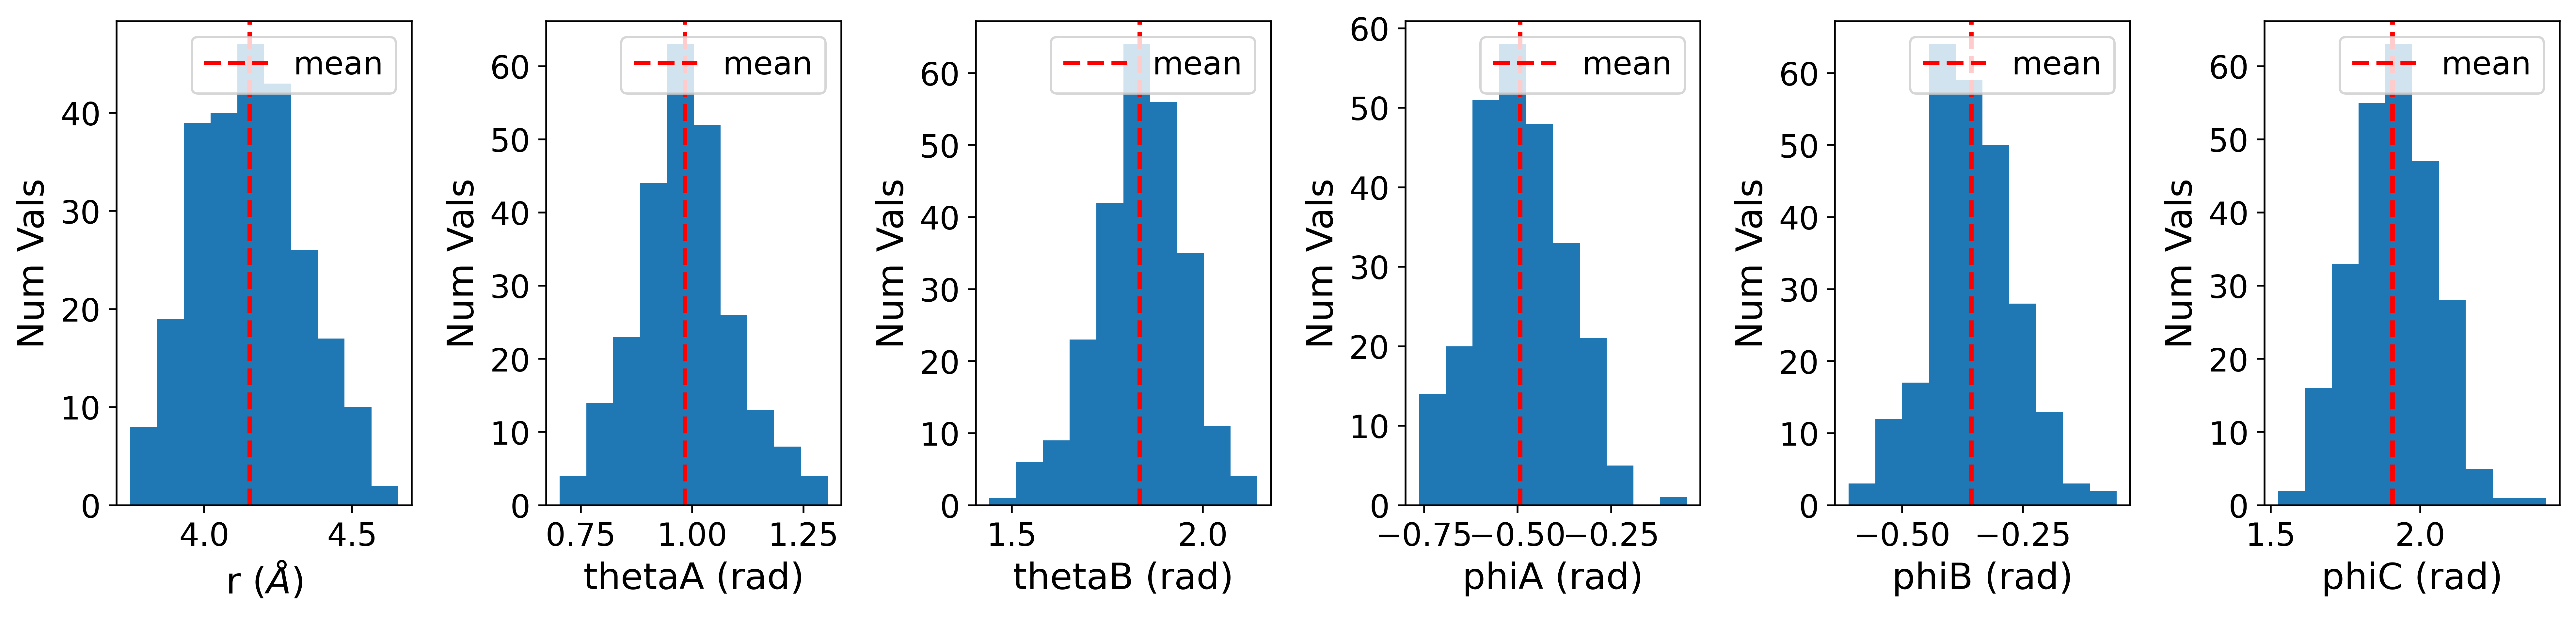

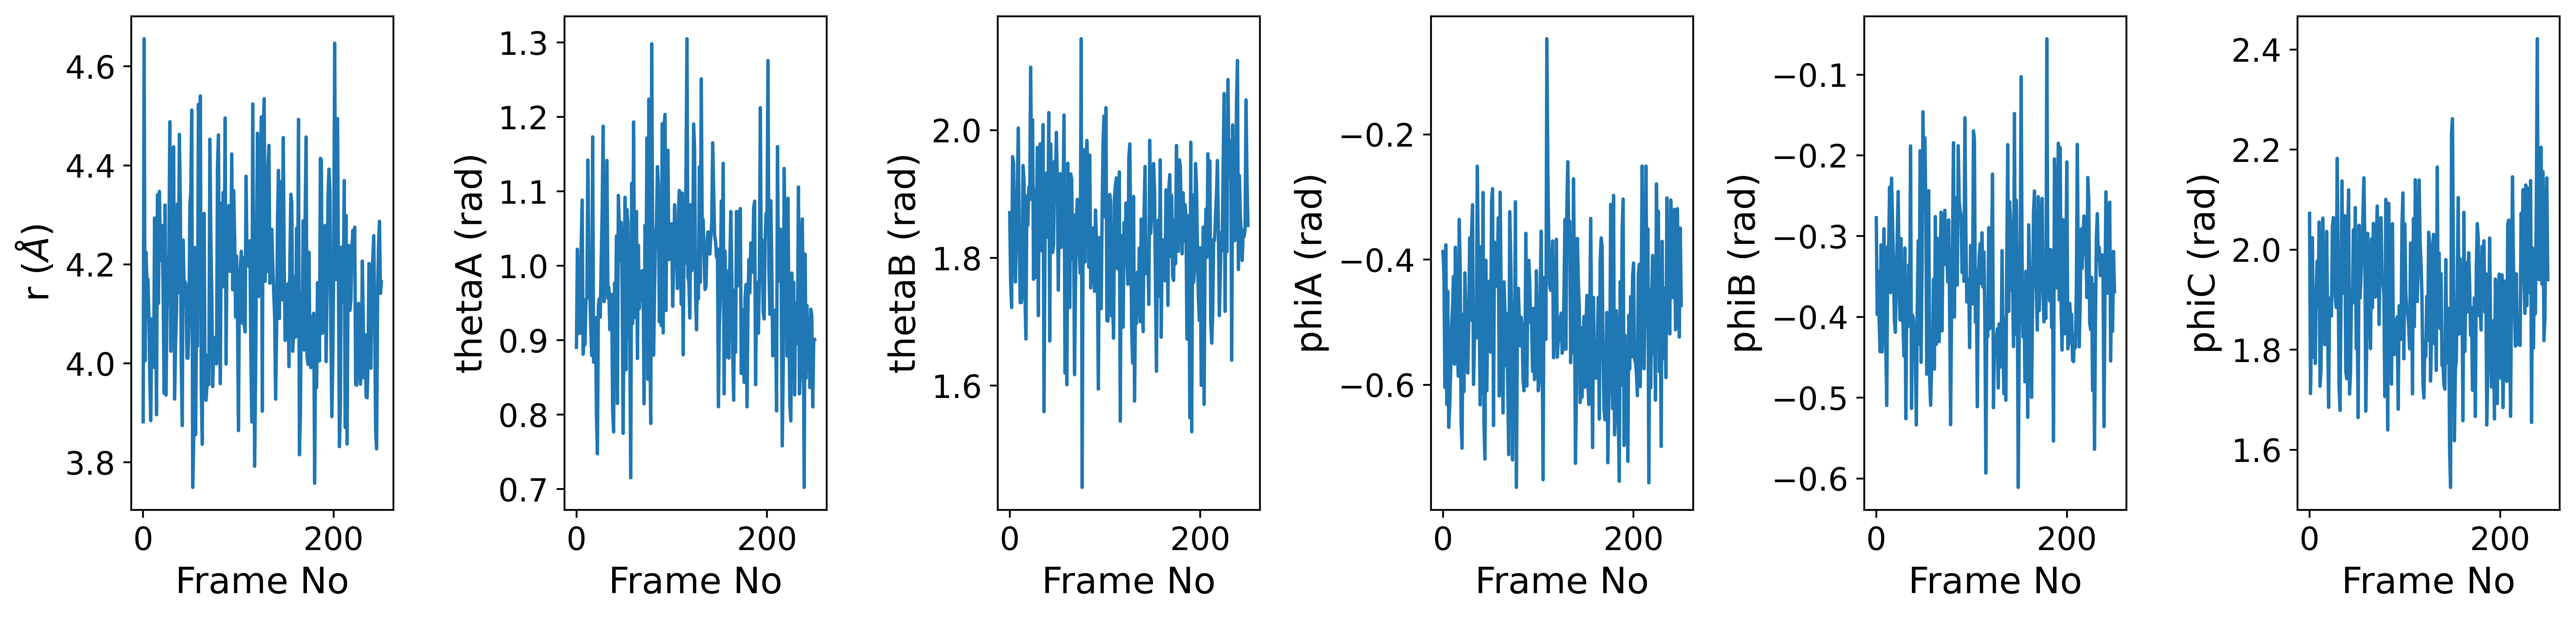

In [8]:
# Load the trajectory
traj = BSS.Trajectory.Trajectory(trajectory="output/restraint_search/gromacs.xtc",
                                 topology="input/complex/mif_mif180.prm7")

# Search for the optimal Boresch restraints
restraint = BSS.FreeEnergy.RestraintSearch.analyse("output/restraint_search", system, traj, 
                                                    298 * BSS.Units.Temperature.kelvin, method='BSS')

There are two possible methods for selecting the restraints in BioSimSpace - these are:

- "MDRestraintsGenerator": This finds the restraints using the package [MDRestraintsGenerator](https://github.com/IAlibay/MDRestraintsGenerator) written by Irfan Alibay. Also see [this paper](https://www.nature.com/articles/s42004-022-00721-4). Candidate sets of Boresch restraints are generated and the fluctuations of the associated Boresch degrees of freedom are tracked over the unrestrained simulation. The optimum Boresch degrees of freedom are then selected as the set having the lowest total variance, and satisfying certain geometric criteria to ensure stability. The force constants of the restraints are set to some pre-defined value (here 10 kcal mol $\mathrm{^{-1}}$ &#x212B;$\mathrm{^{-2}}$ or kcal mol $\mathrm{^{-1}}$ $\mathrm{rad^{-2}}$).

- "BSS": The inbuilt BioSimSpace method. This was inspired by the MDRestraintsGenerator method. The optimum Boresch degrees of freedom are selected in a similar way to MDRestraintsGenerator, although the selection is made based on minimum configurational volume accessible to the restrained non-interacting ligand, rather than total variance, and the force constants are calculated to mimic the native protein-ligand interactions.

 We've used the BSS method, but feel free to try the MDAnalysis method. It's always a good idea to check the distributions of the Boresch degrees of freedom over the course of the simulations and their values against simulation time (both are provided when using the BSS method, but MDRestraintsGenerator only provides the former). Check the output directory to see the plots.

##### <span style="color:skyblue"> Exercise: Issues with Restraint Selection </span> <span style="color:purple">(Extra)</span> 
What issues could arise during the restraint selection stage? How might the plots mentioned above help to diagnose some of these issues?


- One possible issue is that there could be several slowly-interconverting binding poses. This may show up as a multimodal distribution in the histograms, with infrequent transitions between poses evident from the plots of the values of the Boresch degrees of freedom against time. This would represent a sampling issue, as equilibrium sampling of the binding poses would be required to obtain correct free energies, at least while turning on the restraints. This should be dealt with using either enhanced sampling of the two poses, or by performing separate binding free energy calculations for each pose and combining the answers, as described in the analysis notebook.

 The RestraintSearch has returned a restraint object:

In [9]:
type(restraint)

BioSimSpace.Sandpit.Exscientia.FreeEnergy._restraint.Restraint

We can obtain $\Delta\textit{G}_{\textrm{Release}}^o$ by using the `getCorrection` method:

In [10]:
restraint.getCorrection()

-10.5270 kcal/mol

And we can check the anchor points, force constants, and equilibrium values selected by printing out the restraint in SOMD format:

In [11]:
restraint.toString(engine="Somd")

'boresch restraints dictionary = {"anchor_points":{"r1":51, "r2":49, "r3":53, "l1":3, "l2":5, "l3":11}, "equilibrium_values":{"r0":4.15, "thetaA0":0.98, "thetaB0":1.83,"phiA0":-0.49, "phiB0":-0.36, "phiC0":1.91}, "force_constants":{"kr":9.27, "kthetaA":26.33, "kthetaB":22.39, "kphiA":58.47, "kphiB":93.16, "kphiC":43.01}}'

Note that the SOMD restraint string uses atom indices and units of &#x212B;, $\mathrm{rad}$, and $\mathrm{kcal}$ $\mathrm{mol^{-1}}$. Also, the force constants, $k$, are defined as $E = k(x - x_0)^2$. This means that the force constants are halved in order to be consistent with the definition $E = \frac{1}{2} k(x - x_0)^2$.

##### <span style="color:skyblue"> Exercise: Visualise the Anchor Points </span>

Let's view the anchor atoms to make sure they're sensible. [This page](https://nglviewer.org/ngl/api/manual/usage/selection-language.html) on the NGLViewer selection language may be helpful. To view the anchor atoms:

- Run the cell below
- For the default ball and stick representation, select only the ligand atoms

<img src="images/ngl_new_1.png" width="400"/>

- Click on the menu

<img src="images/ngl_new_2.png" width="400"/>

- Create a new "cartoon" representation. This will only display the protein

<img src="images/ngl_new_3.png" width="400"/>

- To visualise the anchor points, add a "spacefill" representation. Then input the selection "@idx1,idx2,id3,..." where the idxs are the indices of the anchor points

In [12]:
view = BSS.Notebook.View(system)
view.molecules([0,1,2,3]) # View the ligand and all three protein chains
#FIXME: Follow the instructions above to view the anchor points

ThemeManager()

NGLWidget(gui_style='ngl')

Do the selected anchor points appear reasonable? Why have they been selected?

##### <span style="color:skyblue"> Exercise: Modify the Restraint Selection </span> <span style="color:purple">(Extra)</span> 

Repeat the restraints derivation but modify the behaviour of BSS.FreeEnergy.RestraintSearch.analyse so that ligand anchor atoms in the triazole ring are selected. You can obtain the atom names by hovering the cursor in NGLView. Multiple atoms can be selected by name in the [MDAnalysis atom selection language](https://userguide.mdanalysis.org/stable/selections.html) as "name atname1 atname2 atname3..."

Searching for low variance pairs. Frame no:   0%|          | 0/251 [00:00<?, ?it/s]

Scoring candidate Boresch anchor points. Anchor set no:   0%|          | 0/50 [00:00<?, ?it/s]

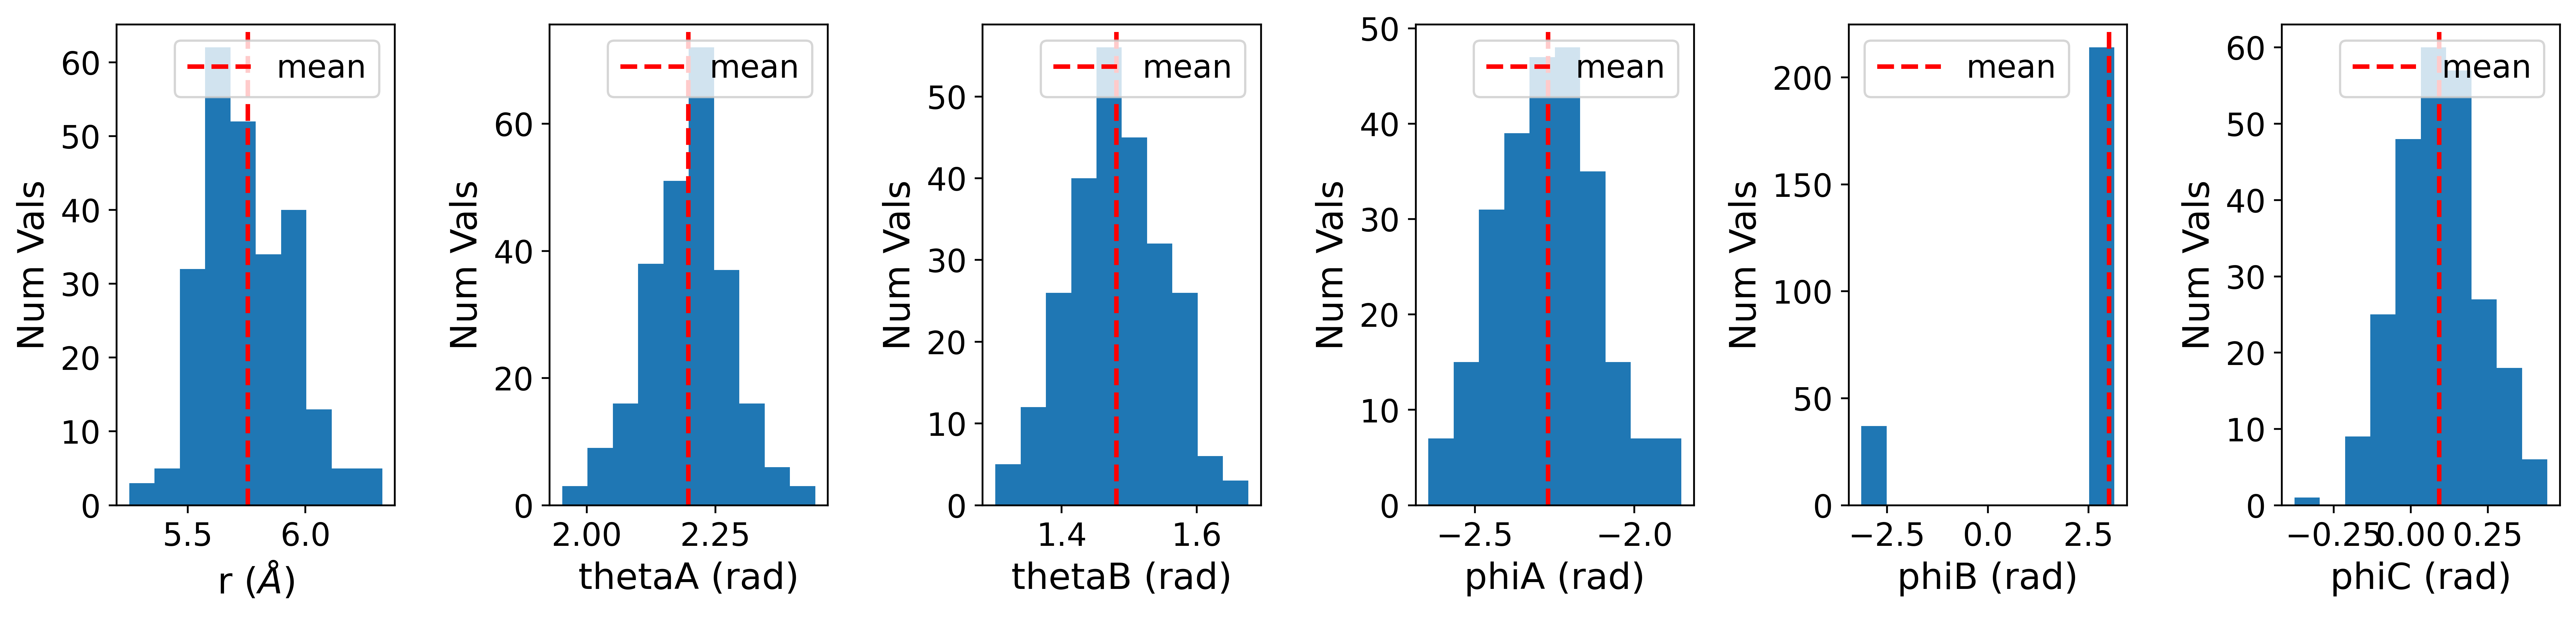

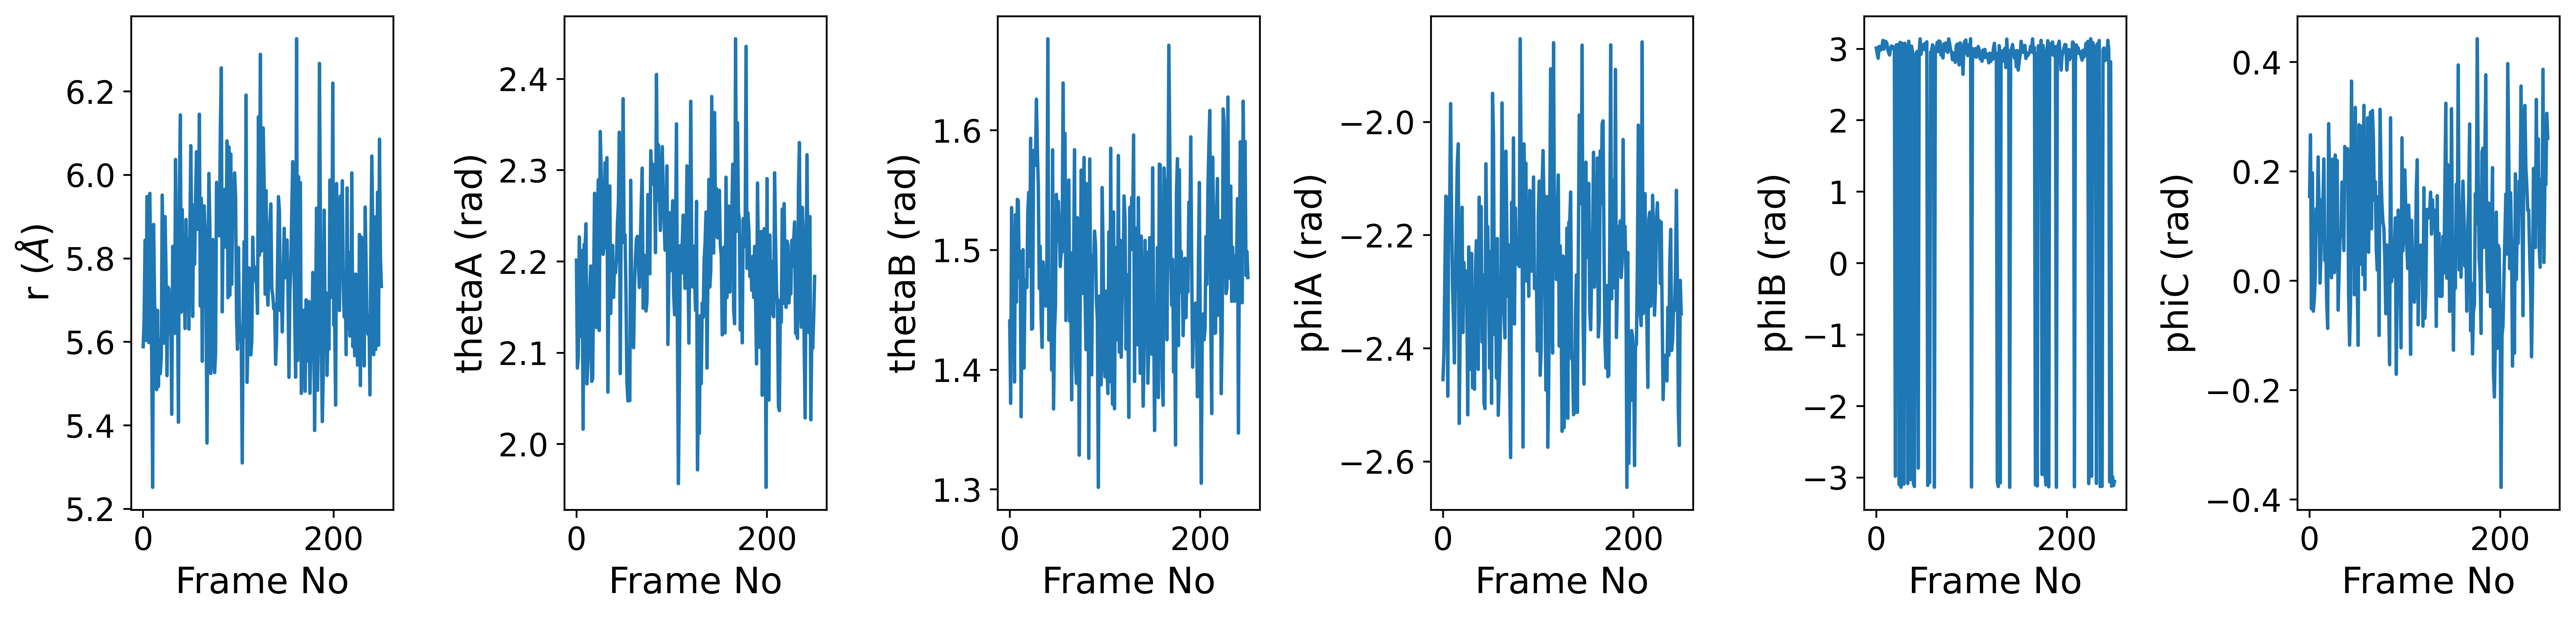

In [13]:
traj = BSS.Trajectory.Trajectory(trajectory="output/restraint_search/gromacs.xtc",
                                 topology="input/complex/mif_mif180.prm7")
                                 
restraint = BSS.FreeEnergy.RestraintSearch.analyse("output/restraint_search", system, traj, 
                                                    298 * BSS.Units.Temperature.kelvin, cutoff=8, method='BSS', append_to_lig_selection="name CAR CAL NAV NAM NAN")

In [14]:
# Check the indices of the anchor points, which can be visualised as shown above
restraint.toString(engine="SOMD")

'boresch restraints dictionary = {"anchor_points":{"r1":952, "r2":950, "r3":954, "l1":10, "l2":13, "l3":20}, "equilibrium_values":{"r0":5.75, "thetaA0":2.20, "thetaB0":1.48,"phiA0":-2.27, "phiB0":3.01, "phiC0":0.09}, "force_constants":{"kr":8.27, "kthetaA":43.42, "kthetaB":59.98, "kphiA":33.16, "kphiB":46.68, "kphiC":48.60}}'

#### <span style="color:teal">2.6 Setting Up The Bound Leg Simulations</span>
<a id="bound"></a>

Now that we have our restraints, we can set up the bound leg simulations. These are managed by `BSS.FreeEnergy.Absolute`. We will need to run three bound leg simulations to account for turning on the restraints, discharging (Coulombic interactions), and vanishing (Lennard-Jones interactions) the ligand. Note that the perturbation types required for these stages are "restraint", "discharge_soft", and "vanish_soft", respectively.

One important parameter is the number of $\mathrm{\lambda}$ windows selected, as their number and spacing will affect the reliability of the free energy estimates in an estimator-dependent way. We plan to use the [multistate Bennett acceptance ratio (MBAR)](https://aip.scitation.org/doi/full/10.1063/1.2978177), which requires sufficient phase space overlap between adjacent $\mathrm{\lambda}$ windows - we must have a high enough probability of observing the samples we generate at one value of $\mathrm{\lambda}$ at the neighbouring values of $\mathrm{\lambda}$. Unfortunately, the optimum set of $\mathrm{\lambda}$ values is system-specific and is not easily predicted before running any simulations. For this system, we ran a test simulation with a set of lambda windows taken from a previous study and added or removed windows to ensure sufficient overlap without having too many windows, which would be a waste of simulation time. 

An example overlap matrix (discharge stage of the bound leg) for the final set of $\mathrm{\lambda}$ windows is shown below:

<img src="images/overlap_mat.png" width="400"/>

The first off-diagonal terms are sufficiently large (much greater than 0.03), indicating good overlap and giving us some confidence that the MBAR estimate will be reliable.

<span style="color:pink">Further reading </span>: 8.3 (The multistate Bennett acceptance ratio), 8.5 (Overlap matrix)

Note that initially, the output directory does not contain "restrain" and "discharge" directories:

In [15]:
! ls output

discharge	free_vanish  restrain	       restraint_search.py
free_discharge	gromacs      restraint_search  vanish


In [16]:
# Set up restraining stage
lam_vals_restrain = [0.000, 0.250, 0.500, 1.000]
restrain_protocol = BSS.Protocol.FreeEnergy(runtime=6*BSS.Units.Time.nanosecond, lam_vals=lam_vals_restrain, perturbation_type="restraint")
restrain_fe_calc = BSS.FreeEnergy.Absolute(restraint.system, restrain_protocol, engine='somd', restraint=restraint, work_dir='output/restrain')

# Set up discharging stage
lam_vals_discharge = [0.000, 0.143, 0.286, 0.429, 0.571, 0.714, 0.857, 1.000]
discharge_protocol = BSS.Protocol.FreeEnergy(runtime=6*BSS.Units.Time.nanosecond, lam_vals=lam_vals_discharge, perturbation_type="discharge_soft")
discharge_fe_calc = BSS.FreeEnergy.Absolute(restraint.system, discharge_protocol, engine='somd', restraint=restraint, work_dir='output/discharge')

BioSimSpace has set up the required `work_dir`s for each stage of the calculation, and all the files needed to run the simulation should have been set up. Have a look!

In [17]:
! ls output

discharge	free_vanish  restrain	       restraint_search.py
free_discharge	gromacs      restraint_search  vanish


We could run the simulations using:

```Python
restrain_fe_calc.run()
discharge_fe_calc.run()
```
However, these would take many hours to run, so we'll avoid starting them now.

##### <span style="color:skyblue"> Exercise: Set Up the Vanish Stage Calculations </span>

Now it's your turn: complete the code below to set up the vanish stage calculations for the vanish stage, using SOMD and a 1 fs timestep:

In [18]:
# Set up the vanish stage
lam_vals_vanish = [0.000, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150, 0.175, 0.200, # We need a lot of these to
                   0.225, 0.250, 0.275, 0.300, 0.325, 0.350, 0.375, 0.400, 0.425, # ensure sufficient overlap
                   0.450, 0.475, 0.500, 0.525, 0.550, 0.575, 0.600, 0.625, 0.650, # between windows!
                   0.675, 0.700, 0.725, 0.750, 0.800, 0.850, 0.900, 0.950, 1.000] 

vanish_protocol = BSS.Protocol.FreeEnergy(runtime=6*BSS.Units.Time.nanosecond, 
                                             timestep=1*BSS.Units.Time.femtosecond, 
                                             lam_vals=lam_vals_vanish, 
                                             perturbation_type="vanish_soft")

vanish_fe_calc = BSS.FreeEnergy.Absolute(restraint.system, vanish_protocol, 
                                         engine='somd', restraint=restraint, 
                                         work_dir='output/vanish')

##### <span style="color:skyblue"> Exercise: Setting up the Free Leg Simulations </span> <span style="color:purple">(Extra)</span>
 Of course, to obtain the overall free energy of binding we must perform the free leg calculations as well, where we discharge and vanish the ligand in a box of water. Set up the free leg simulations using BioSimSpace. You will find the equilibrated input files in input/free_ligand.

In [19]:


# Set up free discharge stage
lam_vals_discharge_free = [0.000, 0.143, 0.286, 0.429, 0.571, 0.714, 0.857, 1.000]

free_discharge_protocol = BSS.Protocol.FreeEnergy(runtime=6*BSS.Units.Time.nanosecond, 
                                                  lam_vals=lam_vals_discharge_free, perturbation_type="discharge_soft")

free_discharge_fe_calc = BSS.FreeEnergy.Absolute(restraint.system, free_discharge_protocol, engine='somd',
                                                 restraint=restraint, work_dir='output/free_discharge')

# Set up the free vanish stage. Notice that far fewer lambda windows are required than for the bound vanish stage
lam_vals_vanish_free = [0.000, 0.028, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 
                        0.500, 0.556, 0.611, 0.667, 0.722, 0.778, 0.889, 1.000]

free_vanish_protocol = BSS.Protocol.FreeEnergy(runtime=6*BSS.Units.Time.nanosecond, 
                                             lam_vals=lam_vals_vanish_free, perturbation_type="vanish_soft")

free_vanish_fe_calc = BSS.FreeEnergy.Absolute(restraint.system, free_vanish_protocol, engine='somd', 
                                            restraint=restraint, work_dir='output/free_vanish')

##### <span style="color:skyblue"> Exercise: Setting up the Bound Stage Calculations for GROMACS </span> <span style="color:purple">(Extra)</span> 
Repeat the set up of the bound calculations for GROMACS. Note that the perturbation type must be "full" (restraining, discharging and vanishing carried out in a single simulation) and the lambda values should be supplied as a pandas data frame (because GROMACS allows different lambda values to be specified simultaneously for each stage):

```Python
lam_vals=pd.DataFrame(data={'bonded': [0.0, ... 1.0],
                            'coul': [0.0, ... 1.0],
                            'vdw':  [0.0, ... 1.0]}))
```
Because of this, the initial value of lambda must be set as a pandas series:
```Python
lam=pd.Series(data={'bonded': 0.0, 'coul': 0.0, 'vdw': 0.0}),
```
Remember to supply the above information when specifying the protocol.

In [20]:
# Need pandas to create lam vals dataframe
import pandas as pd

# Example set of lambda values not tested with this system
gromacs_lam_vals=pd.DataFrame(
                data={'bonded': [0.0, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.35, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                      'coul': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16, 0.33, 0.5, 0.67, 0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                      'vdw':  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]}
                         )

# The initial value of lambda
initial_lam=pd.Series(data={'bonded': 0.0, 'coul': 0.0, 'vdw': 0.0}),
                         
gromacs_protocol = BSS.Protocol.FreeEnergy(runtime=6*BSS.Units.Time.nanosecond, 
                                          lam=initial_lam,
                                          lam_vals=gromacs_lam_vals, 
                                          perturbation_type="full")

gromacs_fe_calc = BSS.FreeEnergy.Absolute(restraint.system, gromacs_protocol, 
                                         engine='gromacs', restraint=restraint, 
                                         work_dir='output/gromacs')

NameError: name 'initial_lam' is not defined

#### <span style="color:teal">2.7 Running the ABFE Calculations</span>
<a id="running"></a>

In reality, we would generally run a large set of calculations including several complete repeat runs. To run such calculations on a cluster, we would recommend taking the approach discussed in the RBFE notebook, using BioSimSpace for the simulation setup and Slurm submission scripts to run the simulations. 

Please head over to the "analysis_abfe" notebook to learn about the analysis of ABFE calculations.